number of patients: 92
all: 74.55434782608695 60332.24704631381
mutect: 13.130434782608695 358.54820415879016
muse: 2.608695652173913 48.607750472589785
somaticsniper: 1.934782608695652 25.017485822306238
varscan: 11.532608695652174 1083.3576323251418
mutect+muse: 7.141304347826087 240.29525047258977
mutect+somaticsniper: 1.0217391304347827 7.695179584120985
mutect+varscan: 7.260869565217392 299.8884688090737
muse+somaticsniper: 0.532608695652174 2.2706758034026464
muse+varscan: 1.4130434782608696 9.981568998109642
somaticsniper+varscan: 8.206521739130435 566.6421313799622
mutect+muse+somaticsniper: 4.967391304347826 335.053284499055
mutect+muse+varscan: 6.967391304347826 310.7489366729679
mutect+somaticsniper+varscan: 1.7717391304347827 31.958766540642728
muse+somaticsniper+varscan: 6.836956521739131 621.9625472589793


<Figure size 432x288 with 0 Axes>

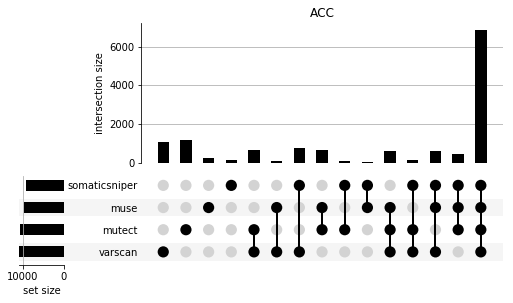

number of patients: 408
all: 198.2328431372549 80903.69333309302
mutect: 38.875 2663.2564338235293
muse: 10.813725490196079 157.5192233756248
somaticsniper: 1.5196078431372548 4.156478277585544
varscan: 6.791666666666667 63.135518790849666
mutect+muse: 21.607843137254903 837.8069973087274
mutect+somaticsniper: 2.8676470588235294 27.855031718569784
mutect+varscan: 16.323529411764707 259.51297577854666
muse+somaticsniper: 0.5073529411764706 0.7058282871972319
muse+varscan: 4.485294117647059 40.249783737024224
somaticsniper+varscan: 2.406862745098039 23.952109765474816
mutect+muse+somaticsniper: 4.737745098039215 46.77190864090734
mutect+muse+varscan: 40.13235294117647 3274.0903258362173
mutect+somaticsniper+varscan: 6.514705882352941 58.33311707035755
muse+somaticsniper+varscan: 11.411764705882353 351.64907727797


<Figure size 432x288 with 0 Axes>

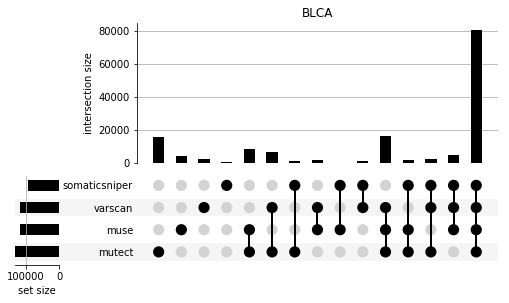

number of patients: 975
all: 58.55692307692308 31958.669323865877
mutect: 25.673846153846153 3481.869008284023
muse: 3.557948717948718 101.75228297172914
somaticsniper: 0.7651282051282051 1.4658608809993425
varscan: 4.816410256410256 153.3580896778435
mutect+muse: 9.302564102564103 940.4366600920447
mutect+somaticsniper: 0.6564102564102564 1.948612754766601
mutect+varscan: 8.791794871794872 635.1474198553582
muse+somaticsniper: 0.19179487179487179 0.33962498356344517
muse+varscan: 1.1917948717948719 73.42680447074294
somaticsniper+varscan: 0.7815384615384615 3.4794540433925047
mutect+muse+somaticsniper: 1.08 6.141292307692308
mutect+muse+varscan: 17.27897435897436 8453.657557922423
mutect+somaticsniper+varscan: 2.463589743589744 42.6076486522025
muse+somaticsniper+varscan: 2.0605128205128205 141.93582537804073


<Figure size 432x288 with 0 Axes>

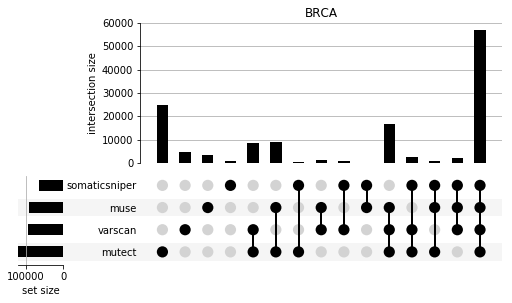

number of patients: 288
all: 242.10069444444446 817953.1113884065
mutect: 41.763888888888886 14439.110918209875
muse: 9.833333333333334 1017.6388888888889
somaticsniper: 1.5729166666666667 5.994683159722222
varscan: 13.23611111111111 1357.4581404320988
mutect+muse: 15.90625 2185.9599609375
mutect+somaticsniper: 2.5659722222222223 31.34286988811728
mutect+varscan: 19.90277777777778 5731.386381172839
muse+somaticsniper: 0.4826388888888889 5.083031925154321
muse+varscan: 2.923611111111111 97.7094425154321
somaticsniper+varscan: 2.4409722222222223 123.11457127700616
mutect+muse+somaticsniper: 3.4340277777777777 40.55120322145061
mutect+muse+varscan: 24.71875 2226.1813151041665
mutect+somaticsniper+varscan: 8.618055555555555 771.3124517746915
muse+somaticsniper+varscan: 14.17361111111111 14974.497636959868


<Figure size 432x288 with 0 Axes>

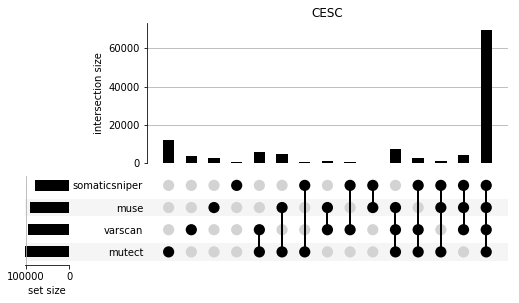

number of patients: 49
all: 59.51020408163265 20775.556018325697
mutect: 21.163265306122447 545.8100791336943
muse: 3.061224489795918 88.09829237817577
somaticsniper: 1.9387755102040816 3.118700541441067
varscan: 15.326530612244898 1317.5260308204913
mutect+muse: 4.020408163265306 60.9179508538109
mutect+somaticsniper: 1.3673469387755102 17.252811328613078
mutect+varscan: 14.693877551020408 2544.5797584339857
muse+somaticsniper: 0.22448979591836735 0.3373594335693461
muse+varscan: 1.2040816326530612 6.244064972927948
somaticsniper+varscan: 1.1020408163265305 5.969179508538111
mutect+muse+somaticsniper: 1.6326530612244898 10.885464389837566
mutect+muse+varscan: 6.612244897959184 140.35985006247395
mutect+somaticsniper+varscan: 3.020408163265306 28.305705955851728
muse+somaticsniper+varscan: 2.7142857142857144 87.75510204081633


<Figure size 432x288 with 0 Axes>

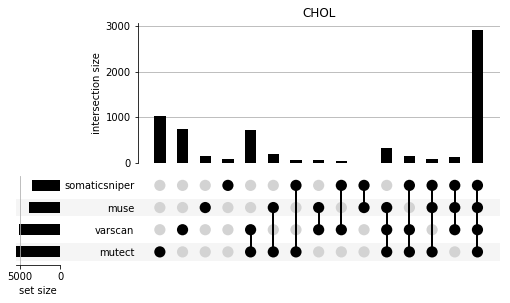

number of patients: 399
all: 367.23308270676694 739429.2263742061
mutect: 85.88220551378446 62301.98863072469
muse: 10.18796992481203 1015.1551434978423
somaticsniper: 2.491228070175439 14.415336587081743
varscan: 33.3984962406015 3637.5680177888335
mutect+muse: 34.59398496240601 8583.29379840579
mutect+somaticsniper: 2.338345864661654 16.690033354061843
mutect+varscan: 83.66917293233082 30066.562232649296
muse+somaticsniper: 0.8471177944862155 5.52299294602421
muse+varscan: 7.0776942355889725 931.4851916759316
somaticsniper+varscan: 7.541353383458647 397.5565605743683
mutect+muse+somaticsniper: 4.446115288220551 49.24459017217228
mutect+muse+varscan: 75.40100250626567 67468.2853122782
mutect+somaticsniper+varscan: 10.06015037593985 533.0891137618482
muse+somaticsniper+varscan: 22.25062656641604 6144.55372767759


<Figure size 432x288 with 0 Axes>

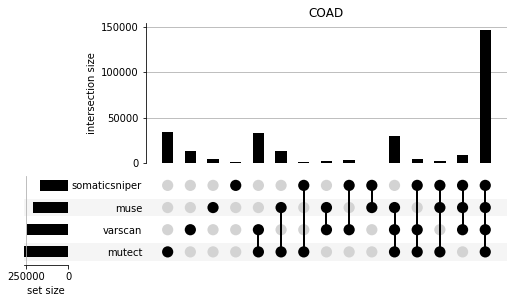

number of patients: 37
all: 109.13513513513513 6429.522279035794
mutect: 21.08108108108108 282.1826150474799
muse: 12.432432432432432 99.6508400292184
somaticsniper: 0.9459459459459459 1.4024835646457268
varscan: 10.216216216216216 59.3046018991965
mutect+muse: 8.972972972972974 36.674945215485764
mutect+somaticsniper: 0.8648648648648649 1.1439006574141712
mutect+varscan: 11.297297297297296 91.18188458729
muse+somaticsniper: 0.918918918918919 3.3177501826150477
muse+varscan: 2.6486486486486487 8.390065741417093
somaticsniper+varscan: 4.621621621621622 26.28926223520818
mutect+muse+somaticsniper: 2.189189189189189 12.802045288531776
mutect+muse+varscan: 16.18918918918919 342.9642074506939
mutect+somaticsniper+varscan: 3.4054054054054053 7.862673484295107
muse+somaticsniper+varscan: 12.216216216216216 145.46676406135867


<Figure size 432x288 with 0 Axes>

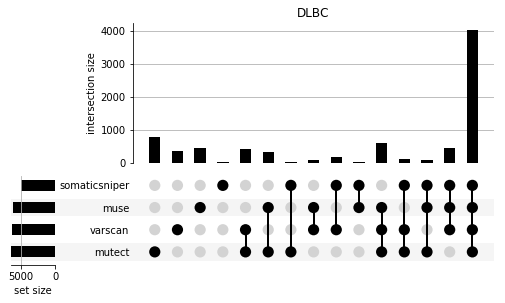

number of patients: 183
all: 138.71584699453553 23644.01761772522
mutect: 34.021857923497265 1909.8137298814534
muse: 4.945355191256831 25.28663143121622
somaticsniper: 1.8852459016393444 3.2928424258711826
varscan: 18.69945355191257 3104.297649974618
mutect+muse: 11.0 127.14754098360656
mutect+somaticsniper: 2.300546448087432 14.603660903580279
mutect+varscan: 29.092896174863387 9667.953118934574
muse+somaticsniper: 0.3770491803278688 0.4534623309146288
muse+varscan: 2.737704918032787 18.466720415658873
somaticsniper+varscan: 2.2950819672131146 20.60145122278957
mutect+muse+somaticsniper: 3.8360655737704916 24.541431514825764
mutect+muse+varscan: 20.546448087431695 1075.5921048702558
mutect+somaticsniper+varscan: 8.05464480874317 105.45056585744572
muse+somaticsniper+varscan: 4.770491803278689 99.193227626982


<Figure size 432x288 with 0 Axes>

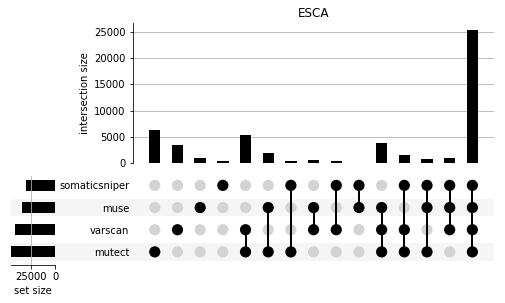

number of patients: 384
all: 91.41145833333333 377539.6588270399
mutect: 83.96875 74038.92610677083
muse: 3.8541666666666665 311.7235243055555
somaticsniper: 0.8125 6.022135416666667
varscan: 5.575520833333333 269.218254937066
mutect+muse: 7.9453125 2108.8173217773438
mutect+somaticsniper: 0.8151041666666666 11.405917697482643
mutect+varscan: 6.786458333333333 902.5012749565971
muse+somaticsniper: 0.3098958333333333 1.0263604058159723
muse+varscan: 3.1302083333333335 1220.2330457899304
somaticsniper+varscan: 2.8098958333333335 106.08104790581596
mutect+muse+somaticsniper: 2.2552083333333335 107.17966037326386
mutect+muse+varscan: 19.348958333333332 37455.89906141494
mutect+somaticsniper+varscan: 2.6614583333333335 95.28122287326387
muse+somaticsniper+varscan: 8.541666666666666 9953.727430555557


<Figure size 432x288 with 0 Axes>

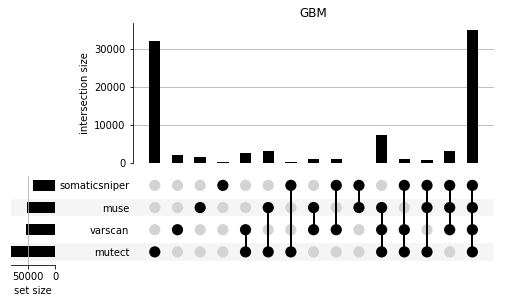

number of patients: 503
all: 114.28230616302187 39652.58829527804
mutect: 25.568588469184892 1934.7224327988333
muse: 4.568588469184891 31.97491788829647
somaticsniper: 0.6998011928429424 1.4625645728017582
varscan: 4.326043737574553 61.201846574627794
mutect+muse: 12.145129224652088 354.3149216035793
mutect+somaticsniper: 0.8330019880715706 3.4909983439324295
mutect+varscan: 14.43737574552684 510.6993585208431
muse+somaticsniper: 0.3061630218687873 0.44304352809583847
muse+varscan: 2.246520874751491 12.464078352943966
somaticsniper+varscan: 1.1809145129224652 4.60941705631025
mutect+muse+somaticsniper: 1.9662027833001987 30.959096316731813
mutect+muse+varscan: 30.218687872763418 2072.8428316779246
mutect+somaticsniper+varscan: 3.73558648111332 23.248176942322207
muse+somaticsniper+varscan: 4.5168986083499005 119.87993312490856


<Figure size 432x288 with 0 Axes>

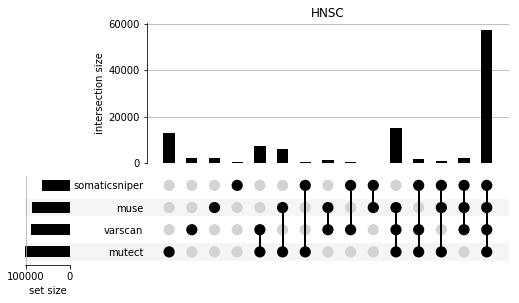

number of patients: 66
all: 22.848484848484848 6015.825528007345
mutect: 10.121212121212121 166.71258034894402
muse: 0.803030303030303 4.218778696051423
somaticsniper: 0.8484848484848485 1.91643709825528
varscan: 5.166666666666667 54.80555555555556
mutect+muse: 1.9393939393939394 26.269054178145097
mutect+somaticsniper: 0.4393939393939394 2.2766299357208446
mutect+varscan: 3.015151515151515 23.166437098255287
muse+somaticsniper: 0.13636363636363635 0.32988980716253447
muse+varscan: 0.6363636363636364 2.5950413223140494
somaticsniper+varscan: 1.606060606060606 34.17814508723599
mutect+muse+somaticsniper: 1.5454545454545454 28.91460055096418
mutect+muse+varscan: 3.1515151515151514 51.401285583103785
mutect+somaticsniper+varscan: 0.8181818181818182 9.421487603305792
muse+somaticsniper+varscan: 1.4090909090909092 12.575068870523417


<Figure size 432x288 with 0 Axes>

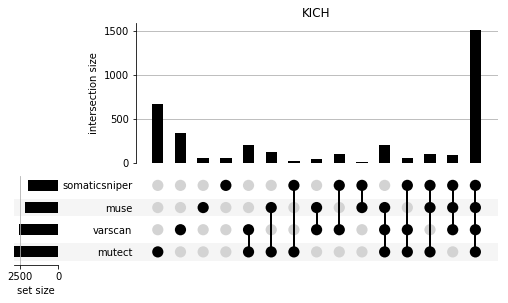

number of patients: 335
all: 38.47761194029851 1278.8286032523945
mutect: 15.794029850746268 12644.456083760302
muse: 1.6746268656716419 2.5956248607707733
somaticsniper: 0.417910447761194 0.5298284695923368
varscan: 2.925373134328358 12.194430830920027
mutect+muse: 4.573134328358209 14.429725996881263
mutect+somaticsniper: 0.2 0.2316417910447761
mutect+varscan: 8.719402985074627 77.99887725551349
muse+somaticsniper: 0.14925373134328357 0.14488750278458454
muse+varscan: 0.7373134328358208 0.9996524838494097
somaticsniper+varscan: 0.8597014925373134 1.5713611049231453
mutect+muse+somaticsniper: 0.4597014925373134 1.078226776564937
mutect+muse+varscan: 10.405970149253731 97.54265092448207
mutect+somaticsniper+varscan: 0.9074626865671642 1.2242726665181558
muse+somaticsniper+varscan: 1.492537313432836 3.7066607262196483


<Figure size 432x288 with 0 Axes>

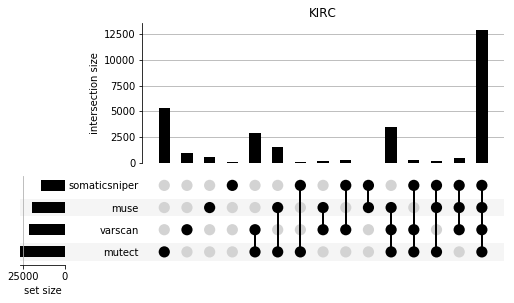

number of patients: 280
all: 56.267857142857146 940.117538265306
mutect: 7.635714285714286 23.31015306122449
muse: 1.9892857142857143 3.7463137755102043
somaticsniper: 0.5714285714285714 0.6663265306122449
varscan: 3.7714285714285714 8.797755102040817
mutect+muse: 3.592857142857143 9.469948979591836
mutect+somaticsniper: 0.5214285714285715 0.7495408163265306
mutect+varscan: 10.25 43.294642857142854
muse+somaticsniper: 0.16785714285714284 0.21825255102040814
muse+varscan: 0.6392857142857142 1.0805994897959186
somaticsniper+varscan: 1.5642857142857143 4.938724489795919
mutect+muse+somaticsniper: 0.9464285714285714 1.650701530612245
mutect+muse+varscan: 4.360714285714286 43.57345663265305
mutect+somaticsniper+varscan: 1.1428571428571428 1.6224489795918369
muse+somaticsniper+varscan: 2.225 5.074375


<Figure size 432x288 with 0 Axes>

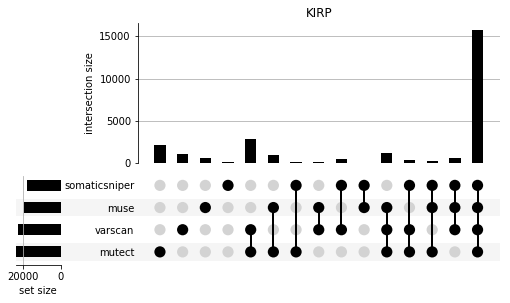

number of patients: 113
all: 10.097345132743364 517.114417730441
mutect: 50.39823008849557 40074.9122092568
muse: 2.327433628318584 88.94588456417888
somaticsniper: 2.663716814159292 17.74532069856684
varscan: 6.20353982300885 679.6842352572638
mutect+muse: 8.008849557522124 1011.884877437544
mutect+somaticsniper: 1.5044247787610618 7.5597149346072525
mutect+varscan: 5.292035398230088 479.8881666536142
muse+somaticsniper: 0.061946902654867256 0.09350771399483124
muse+varscan: 0.7433628318584071 14.456261257733578
somaticsniper+varscan: 2.327433628318584 76.30871642258596
mutect+muse+somaticsniper: 0.49557522123893805 2.3561751115984015
mutect+muse+varscan: 5.495575221238938 494.0021928107134
mutect+somaticsniper+varscan: 4.743362831858407 74.17307541702561
muse+somaticsniper+varscan: 0.8938053097345132 11.192262510768265


<Figure size 432x288 with 0 Axes>

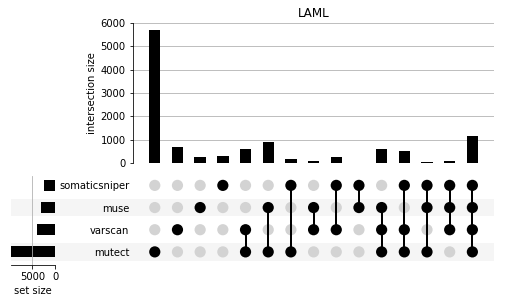

number of patients: 500
all: 41.538 177401.13255600003
mutect: 12.406 7095.121163999999
muse: 1.588 292.9422559999999
somaticsniper: 0.272 1.210016
varscan: 2.712 309.7050559999998
mutect+muse: 4.342 2358.7930360000014
mutect+somaticsniper: 0.344 3.529664
mutect+varscan: 4.938 1154.2181560000001
muse+somaticsniper: 0.09 0.35390000000000027
muse+varscan: 0.812 69.39265599999999
somaticsniper+varscan: 0.548 15.879696000000006
mutect+muse+somaticsniper: 0.634 3.8800440000000007
mutect+muse+varscan: 5.71 2027.8339
mutect+somaticsniper+varscan: 1.128 71.15561600000008
muse+somaticsniper+varscan: 3.468 3618.472975999999


<Figure size 432x288 with 0 Axes>

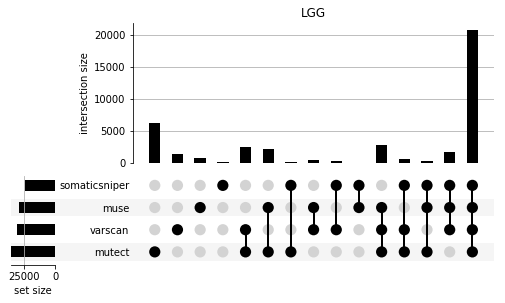

number of patients: 361
all: 99.86980609418282 14676.645099408383
mutect: 15.105263157894736 267.0138504155125
muse: 3.074792243767313 14.861442131352582
somaticsniper: 0.8282548476454293 1.3777058187091873
varscan: 6.67590027700831 72.23567959116335
mutect+muse: 8.113573407202216 115.49125620583024
mutect+somaticsniper: 0.9944598337950139 8.13293329547809
mutect+varscan: 9.481994459833794 218.67072843210227
muse+somaticsniper: 0.2188365650969529 0.3039111117931876
muse+varscan: 1.3628808864265929 9.804605550908908
somaticsniper+varscan: 2.601108033240997 31.76332287198533
mutect+muse+somaticsniper: 2.440443213296399 28.922353266165853
mutect+muse+varscan: 12.293628808864266 310.7226463885329
mutect+somaticsniper+varscan: 1.8393351800554016 4.506042771310841
muse+somaticsniper+varscan: 3.6592797783933517 50.717704744438734


<Figure size 432x288 with 0 Axes>

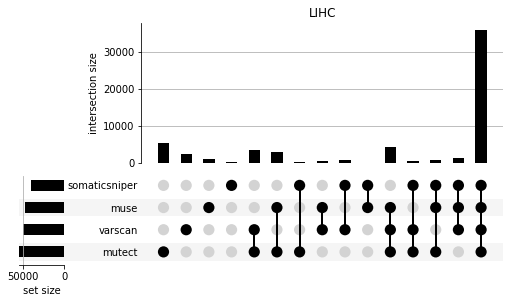

number of patients: 556
all: 194.66906474820144 55488.80415092386
mutect: 50.64928057553957 3519.360808834946
muse: 8.08093525179856 83.02762214688681
somaticsniper: 1.816546762589928 22.408790952849234
varscan: 9.066546762589928 507.17722620464775
mutect+muse: 26.884892086330936 1089.465167434398
mutect+somaticsniper: 2.4244604316546763 53.442135500232915
mutect+varscan: 25.347122302158272 744.0899377620207
muse+somaticsniper: 0.5251798561151079 1.058718492831634
muse+varscan: 4.561151079136691 65.15633248796645
somaticsniper+varscan: 5.320143884892087 324.825565446923
mutect+muse+somaticsniper: 4.821942446043166 388.00966241395366
mutect+muse+varscan: 62.10071942446043 6173.274028259407
mutect+somaticsniper+varscan: 7.246402877697841 80.12453742042337
muse+somaticsniper+varscan: 7.789568345323741 199.69133002950156


<Figure size 432x288 with 0 Axes>

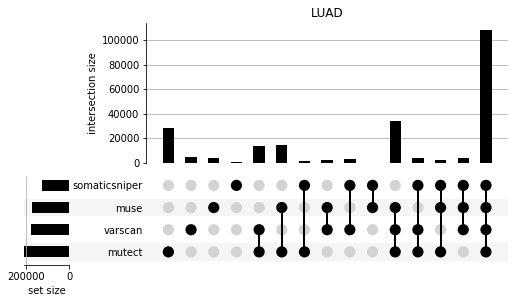

number of patients: 486
all: 222.2037037037037 53358.36385459534
mutect: 37.135802469135804 1227.7963725041918
muse: 7.969135802469136 39.21509678402683
somaticsniper: 1.6893004115226338 4.30470033362123
varscan: 9.734567901234568 179.705265965554
mutect+muse: 22.368312757201647 456.76352266761506
mutect+somaticsniper: 2.580246913580247 15.922572778539857
mutect+varscan: 22.353909465020575 475.0187810123795
muse+somaticsniper: 0.654320987654321 1.073921658283798
muse+varscan: 4.923868312757202 28.8275372995309
somaticsniper+varscan: 4.814814814814815 103.360768175583
mutect+muse+somaticsniper: 5.845679012345679 183.9988187776253
mutect+muse+varscan: 53.251028806584365 3055.8711409168654
mutect+somaticsniper+varscan: 6.742798353909465 67.23220122271333
muse+somaticsniper+varscan: 9.401234567901234 221.4501219326322


<Figure size 432x288 with 0 Axes>

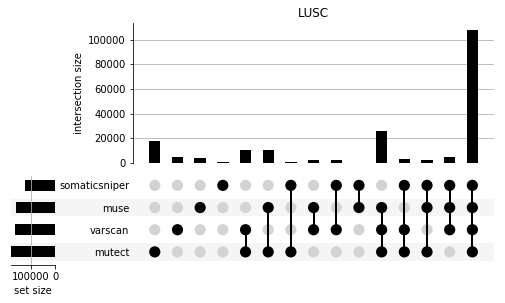

number of patients: 78
all: 28.346153846153847 996.0212031558183
mutect: 7.217948717948718 28.555062458908605
muse: 1.1923076923076923 1.7194280078895456
somaticsniper: 0.28205128205128205 0.3050624589086128
varscan: 2.141025641025641 29.300624589086112
mutect+muse: 2.076923076923077 2.1992110453648914
mutect+somaticsniper: 0.46153846153846156 1.6844181459566072
mutect+varscan: 3.8333333333333335 10.677350427350431
muse+somaticsniper: 0.10256410256410256 0.0920447074293228
muse+varscan: 0.6025641025641025 2.3420447074293227
somaticsniper+varscan: 0.5128205128205128 0.5575279421433268
mutect+muse+somaticsniper: 1.1153846153846154 18.717455621301777
mutect+muse+varscan: 4.987179487179487 23.11522024983563
mutect+somaticsniper+varscan: 0.7435897435897436 0.9086127547666007
muse+somaticsniper+varscan: 0.6666666666666666 1.4017094017094014


<Figure size 432x288 with 0 Axes>

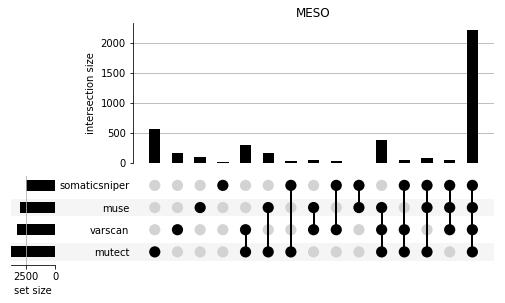

In [1]:
import os, sys, argparse
from upsetplot import from_memberships
from upsetplot import plot
%matplotlib inline 
from matplotlib import pyplot
import numpy as np

# functions
def parse_maf(fp):
	''' Return a dictionary with vars[patient][variant_set]'''
	caller_vars = {}

	fh = open(fp, 'r')
	for line in fh:
		temp = line.strip().split('\t')
		if line[0] == '#' or temp[0] == 'Hugo_Symbol':
			continue
		ID = temp[16] + '_' + temp[17] # 'tumor'_'normal'
		if ID not in caller_vars:
			caller_vars[ID] = set()
		chrom =temp[4]
		s_pos = temp[5]
		e_pos = temp[6]
		ref = temp[11]
		tum_allele_1 = temp[12]
		tum_allele_2 = temp[13]
		var = (chrom, s_pos, e_pos, ref, tum_allele_1, tum_allele_2)
		caller_vars[ID].add(var)

	return(caller_vars)


def two_set(dat_1, dat_2):
    inter_all = 0
    diff_1_all = 0
    diff_2_all = 0

    # intersect patient keys
    patients = set(list(dat_1.keys())) & set(list(dat_2.keys()))
    dat = []
    for patient in patients:
        set_1 = dat_1[patient]
        set_2 = dat_2[patient]
        inter = len(set_1 & set_2)
        diff_1 = len(set_1 - set_2)
        diff_2 = len(set_2 - set_1)

        inter_all = inter_all + inter
        diff_1_all = diff_1_all + diff_1
        diff_2_all = diff_2_all + diff_2
    
    dat.extend([inter_all, diff_1_all, diff_2_all])
    return dat


def three_set(dat_1, dat_2, dat_3):

    inter_all = 0
    diff_1_all = 0
    diff_2_all = 0
    diff_3_all = 0
    inter_12_all = 0
    inter_13_all = 0
    inter_23_all = 0

    # intersect patient keys
    patients = set(list(dat_1.keys())) & set(list(dat_2.keys())) & set(list(dat_3.keys()))
    
    dat = []
    for patient in patients:
        set_1 = dat_1[patient]
        set_2 = dat_2[patient]
        set_3 = dat_3[patient]
        inter = len(set_1 & set_2 & set_3)
        inter_12 = len(set_1 & set_2) - inter
        inter_13 = len(set_1 & set_3) - inter
        inter_23 = len(set_2 & set_3) - inter
        diff_1 = len(set_1) - inter - inter_13 - inter_12
        diff_2 = len(set_2) - inter - inter_12 - inter_23
        diff_3 = len(set_3) - inter - inter_13 - inter_23
        
        inter_all = inter_all + inter
        diff_1_all = diff_1_all + diff_1
        diff_2_all = diff_2_all + diff_2
        diff_3_all = diff_3_all + diff_3
        inter_12_all = inter_12_all + inter_12
        inter_13_all = inter_13_all + inter_13
        inter_23_all = inter_23_all + inter_23

    dat.extend([inter_all, diff_1_all, diff_2_all, diff_3_all, inter_12_all, inter_13_all, inter_23_all])
    return dat


def four_set(dat_1, dat_2, dat_3, dat_4):
    dat = []
    inter_all = 0
    
    interall = []
    
    diff_1_all = 0
    diff_2_all = 0
    diff_3_all = 0
    diff_4_all = 0
    
    diff1all = []
    diff2all = []
    diff3all = []
    diff4all = []
    
    inter_12_all = 0
    inter_13_all = 0
    inter_14_all = 0
    inter_23_all = 0
    inter_24_all = 0
    inter_34_all = 0
    
    inter12all = []
    inter13all = []
    inter14all = []
    inter23all = []
    inter24all = []
    inter34all = []
    
    inter_123_all = 0
    inter_124_all = 0
    inter_134_all = 0
    inter_234_all = 0    
    
    inter123all = []
    inter124all = []
    inter134all = []
    inter234all = []
    
    set1_total = 0
    set2_total = 0
    set3_total = 0
    set4_total = 0
    
    # intersect patient keys
    patients = set(list(dat_1.keys())) & set(list(dat_2.keys())) & set(list(dat_3.keys())) & set(list(dat_4.keys()))
    total = 0
    for patient in patients:
        set_1 = dat_1[patient]
        set_2 = dat_2[patient]
        set_3 = dat_3[patient]
        set_4 = dat_4[patient]
        
        set1_total = set1_total + len(set_1)
        set2_total = set2_total + len(set_2)
        set3_total = set3_total + len(set_3)
        set4_total = set4_total + len(set_4)
        
        
        inter = len(set_1 & set_2 & set_3 & set_4)
        interall.append(inter)
        inter_123 = len(set_1 & set_2 & set_3) - inter
        inter123all.append(inter_123)
        inter_124 = len(set_1 & set_2 & set_4) - inter
        inter124all.append(inter_124)
        inter_134 = len(set_1 & set_3 & set_4) - inter
        inter134all.append(inter_134)
        inter_234 = len(set_2 & set_3 & set_4) - inter
        inter234all.append(inter_234)
        
        
        inter_12 = len(set_1 & set_2) - inter - inter_123 - inter_124
        inter12all.append(inter_12)
        inter_13 = len(set_1 & set_3) - inter - inter_123 - inter_134
        inter13all.append(inter_13)
        inter_14 = len(set_1 & set_4) - inter - inter_124 - inter_134
        inter14all.append(inter_14)
        inter_23 = len(set_2 & set_3) - inter - inter_123 - inter_234
        inter23all.append(inter_23)
        inter_24 = len(set_2 & set_4) - inter - inter_124 - inter_234
        inter24all.append(inter_24)
        inter_34 = len(set_3 & set_4) - inter - inter_234 - inter_134
        inter34all.append(inter_34)
        
        diff_1 = len(set_1) - inter - inter_13 - inter_12 - inter_14 - inter_123 - inter_134 - inter_124
        diff1all.append(diff_1)
        diff_2 = len(set_2) - inter - inter_12 - inter_23 - inter_24 - inter_123 - inter_124 - inter_234
        diff2all.append(diff_2)
        diff_3 = len(set_3) - inter - inter_13 - inter_23 - inter_34 - inter_123 - inter_134 - inter_234
        diff3all.append(diff_3)
        diff_4 = len(set_4) - inter - inter_14 - inter_24 - inter_34 - inter_124 - inter_134 - inter_234
        diff4all.append(diff_4)
        
        inter_all = inter_all + inter
        diff_1_all = diff_1_all + diff_1
        diff_2_all = diff_2_all + diff_2
        diff_3_all = diff_3_all + diff_3
        diff_4_all = diff_4_all + diff_4
        inter_12_all = inter_12_all + inter_12
        inter_13_all = inter_13_all + inter_13
        inter_14_all = inter_14_all + inter_14
        inter_23_all = inter_23_all + inter_23
        inter_24_all = inter_24_all + inter_24
        inter_34_all = inter_34_all + inter_34
        inter_123_all = inter_123_all + inter_123
        inter_124_all = inter_124_all + inter_124
        inter_134_all = inter_134_all + inter_134
        inter_234_all = inter_234_all + inter_234
        total = total + len(set_1 & set_2)
    print("number of patients:", len(patients))
    print("all:", np.mean(interall), np.var(interall))
    print("mutect:", np.mean(diff1all), np.var(diff1all))
    print("muse:", np.mean(diff2all), np.var(diff2all))
    print("somaticsniper:", np.mean(diff3all), np.var(diff3all))
    print("varscan:", np.mean(diff4all), np.var(diff4all))
    print("mutect+muse:", np.mean(inter12all), np.var(inter12all))
    print("mutect+somaticsniper:", np.mean(inter13all), np.var(inter13all))
    print("mutect+varscan:", np.mean(inter14all), np.var(inter14all))
    print("muse+somaticsniper:", np.mean(inter23all), np.var(inter23all))
    print("muse+varscan:", np.mean(inter24all), np.var(inter24all))
    print("somaticsniper+varscan:", np.mean(inter34all), np.var(inter34all))
    print("mutect+muse+somaticsniper:", np.mean(inter123all), np.var(inter123all))
    print("mutect+muse+varscan:", np.mean(inter124all), np.var(inter124all))
    print("mutect+somaticsniper+varscan:", np.mean(inter134all), np.var(inter134all))
    print("muse+somaticsniper+varscan:", np.mean(inter234all), np.var(inter234all))

    dat.extend([inter_all, diff_1_all, diff_2_all, diff_3_all, diff_4_all, inter_12_all, inter_13_all, inter_14_all,
                inter_23_all, inter_24_all, inter_34_all, inter_123_all, inter_124_all, inter_134_all, inter_234_all]) 
    
    return dat



# main
possible_callers = ('mutect', 'muse', 'somaticsniper', 'varscan')
#not all possible cancers, just for testing
possible_cancers = ('ACC', 'BLCA','BRCA','CESC','CHOL','COAD','DLBC','ESCA','GBM','HNSC', 
					'KICH','KIRC','KIRP','LAML','LGG','LIHC','LUAD','LUSC','MESO')


original = os.getcwd()
for cancer in possible_cancers:
    os.chdir(original)
    os.chdir(cancer)
    mafs = os.listdir()

    maf_fps = {}
    for caller in possible_callers:
        for maf in mafs:
            if caller in maf: # str in the filepath
                maf_fps[caller] = maf

    #print(possible_callers)
    #print(maf_fps)

    # parse maf for each caller
    all_variants = {}
    for caller in maf_fps:
        all_variants[caller] = parse_maf(maf_fps[caller])
        
    num_callers = len(possible_callers)
    dat = []
    
    """
    #two ways
    
    for i in range(0, num_callers):
        if i == num_callers:
            break
        for j in range(i + 1, num_callers):
            set_vals = two_set(all_variants[possible_callers[i]], all_variants[possible_callers[j]])
            dat.append(set_vals)
            print(possible_callers[i], possible_callers[j])
            print(set_vals)
    """
    """
    # three ways 
    for i in range(0, num_callers):
        if i == num_callers:
            break
        for j in range(i + 1, num_callers):
            for k in range(j+1, num_callers):
                set_vals = three_set(all_variants[possible_callers[i]], all_variants[possible_callers[j]],all_variants[possible_callers[k]])
                dat.append(set_vals)
                print(possible_callers[i], possible_callers[j], possible_callers[k])
                print(set_vals)
    
    
    print(four_set(all_variants[possible_callers[0]], all_variants[possible_callers[1]],
                        all_variants[possible_callers[2]], all_variants[possible_callers[3]]))
    """
    
    # four way intersection    
    dat = four_set(all_variants[possible_callers[0]], all_variants[possible_callers[1]],
                        all_variants[possible_callers[2]], all_variants[possible_callers[3]])
    #print(possible_callers[0], possible_callers[1], possible_callers[2], possible_callers[3])
    #print(set_vals)
    
    example = from_memberships([['mutect','muse','somaticsniper','varscan'],['mutect'], ['muse'], ['somaticsniper'], 
                                ['varscan'], ['mutect', 'muse'],['mutect', 'somaticsniper'],['mutect', 'varscan'],['muse','somaticsniper'], ['muse', 'varscan'],
                            ['somaticsniper', 'varscan'],['mutect', 'muse', 'somaticsniper'], ['mutect','muse','varscan'], ['mutect', 'somaticsniper', 'varscan'],
                            ['muse','somaticsniper','varscan']],
                           data=dat)
    pyplot.figure()
    ax = plot(example)  
    pyplot.title(cancer)
    pyplot.ylabel('intersection size')
    ax['totals'].set_xlabel('set size')
    pyplot.show()

    
    
    


number of patients: 433
all: 52.20554272517321 2551.5766898324696
mutect: 88.49653579676675 23628.753452202527
muse: 4.099307159353349 34.010923307500704
somaticsniper: 1.2725173210161662 3.431507981801599
varscan: 7.323325635103926 303.5721348985807
mutect+muse: 8.914549653579677 84.20747883875855
mutect+somaticsniper: 1.3233256351039262 2.777677623753927
mutect+varscan: 6.096997690531178 31.736549877592815
muse+somaticsniper: 0.20554272517321015 0.2279600403223656
muse+varscan: 1.2494226327944573 2.432014678194454
somaticsniper+varscan: 3.3625866050808315 29.3812330323379
mutect+muse+somaticsniper: 2.607390300230947 19.98904469062185
mutect+muse+varscan: 11.103926096997691 149.78365664118965
mutect+somaticsniper+varscan: 2.6882217090069283 15.928198454309321
muse+somaticsniper+varscan: 1.928406466512702 8.884019862498599


<Figure size 432x288 with 0 Axes>

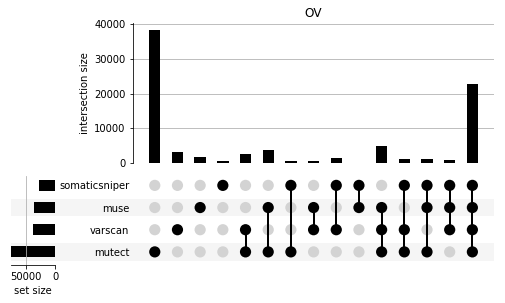

number of patients: 142
all: 73.52112676056338 372025.1791311247
mutect: 21.197183098591548 12294.52449910732
muse: 6.112676056338028 2799.3675857964686
somaticsniper: 0.33098591549295775 1.376363816703035
varscan: 1.471830985915493 21.62948819678635
mutect+muse: 28.887323943661972 52713.74786748661
mutect+somaticsniper: 0.21830985915492956 1.1424816504661774
mutect+varscan: 3.5211267605633805 109.98194802618528
muse+somaticsniper: 0.528169014084507 21.96751636580044
muse+varscan: 8.190140845070422 8057.111733782977
somaticsniper+varscan: 0.4084507042253521 2.7204919658797864
mutect+muse+somaticsniper: 2.436619718309859 428.0628843483436
mutect+muse+varscan: 75.20422535211267 528577.2892779212
mutect+somaticsniper+varscan: 0.43661971830985913 9.696687165244992
muse+somaticsniper+varscan: 5.746478873239437 3538.696290418568


<Figure size 432x288 with 0 Axes>

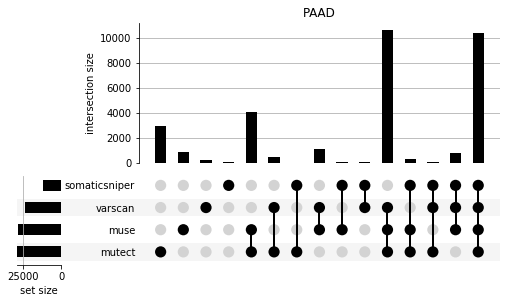

number of patients: 174
all: 6.890804597701149 26.028306249174268
mutect: 3.7528735632183907 6.255020478266613
muse: 0.3793103448275862 0.3963535473642489
somaticsniper: 0.19540229885057472 0.23768001056942795
varscan: 0.5574712643678161 0.476582111243229
mutect+muse: 0.6551724137931034 0.75465715418153
mutect+somaticsniper: 0.13793103448275862 0.16488307570352756
mutect+varscan: 1.0057471264367817 1.3620359360549612
muse+somaticsniper: 0.011494252873563218 0.011362135024441798
muse+varscan: 0.13218390804597702 0.14919408112035937
somaticsniper+varscan: 0.08045977011494253 0.07398599550799312
mutect+muse+somaticsniper: 0.10344827586206896 0.09274673008323427
mutect+muse+varscan: 1.0 1.9310344827586208
mutect+somaticsniper+varscan: 0.19540229885057472 0.23768001056942795
muse+somaticsniper+varscan: 0.25862068965517243 0.2836900515259612


<Figure size 432x288 with 0 Axes>

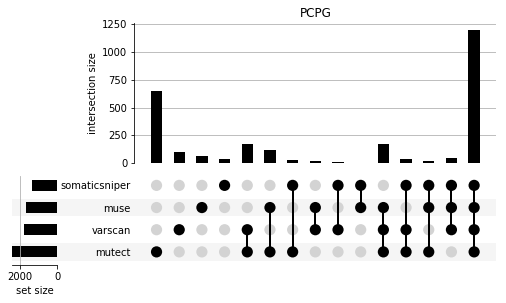

number of patients: 462
all: 35.64069264069264 109430.54189389254
mutect: 10.445887445887445 530.9353835197991
muse: 1.1623376623376624 50.70741271715298
somaticsniper: 0.26406926406926406 1.0601375536440474
varscan: 1.4393939393939394 38.298274957365855
mutect+muse: 3.2489177489177488 302.771373287607
mutect+somaticsniper: 0.4069264069264069 13.072506137441202
mutect+varscan: 5.307359307359308 386.9877813384306
muse+somaticsniper: 0.1038961038961039 0.2013268117164221
muse+varscan: 0.6363636363636364 17.94136166863439
somaticsniper+varscan: 0.4458874458874459 14.026292610708191
mutect+muse+somaticsniper: 0.5411255411255411 16.495061936620374
mutect+muse+varscan: 5.467532467532467 347.84201945240903
mutect+somaticsniper+varscan: 1.6688311688311688 137.69335750829262
muse+somaticsniper+varscan: 2.036796536796537 851.4380399542739


<Figure size 432x288 with 0 Axes>

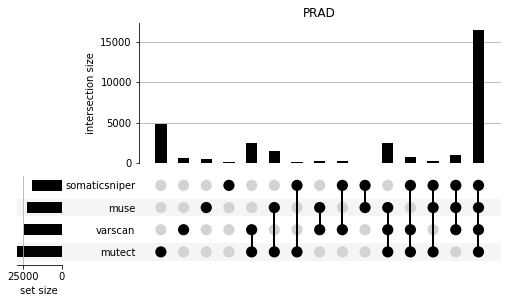

number of patients: 135
all: 302.8296296296296 1869434.926529492
mutect: 61.14074074074074 23952.076488340193
muse: 10.703703703703704 3414.756652949246
somaticsniper: 1.7703703703703704 10.236159122085049
varscan: 17.918518518518518 3637.2452126200265
mutect+muse: 24.6 9008.565925925925
mutect+somaticsniper: 2.577777777777778 122.89580246913579
mutect+varscan: 28.962962962962962 9414.287517146777
muse+somaticsniper: 0.45925925925925926 4.929821673525378
muse+varscan: 6.4148148148148145 1140.0205212620026
somaticsniper+varscan: 4.711111111111111 188.50172839506172
mutect+muse+somaticsniper: 6.0 860.2222222222222
mutect+muse+varscan: 43.44444444444444 27185.93580246914
mutect+somaticsniper+varscan: 9.14074074074074 1397.972784636488
muse+somaticsniper+varscan: 26.155555555555555 24340.72395061728


<Figure size 432x288 with 0 Axes>

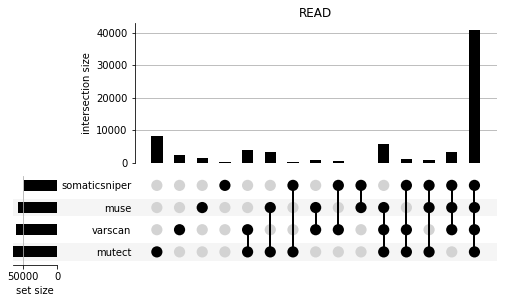

number of patients: 236
all: 70.44067796610169 45308.91597242171
mutect: 19.021186440677965 1085.7156528296464
muse: 2.3262711864406778 16.516428468830792
somaticsniper: 1.4279661016949152 2.304133151393278
varscan: 12.466101694915254 1374.6471559896581
mutect+muse: 5.377118644067797 140.0908323757541
mutect+somaticsniper: 1.5508474576271187 16.272838264866415
mutect+varscan: 8.305084745762711 476.6018385521401
muse+somaticsniper: 0.2033898305084746 0.5857512209135307
muse+varscan: 1.5381355932203389 15.434986354495836
somaticsniper+varscan: 1.1101694915254237 5.801422005170926
mutect+muse+somaticsniper: 2.7711864406779663 169.3798477449009
mutect+muse+varscan: 9.546610169491526 625.6885054582016
mutect+somaticsniper+varscan: 2.26271186440678 31.041151967825332
muse+somaticsniper+varscan: 2.156779661016949 69.2338947141626


<Figure size 432x288 with 0 Axes>

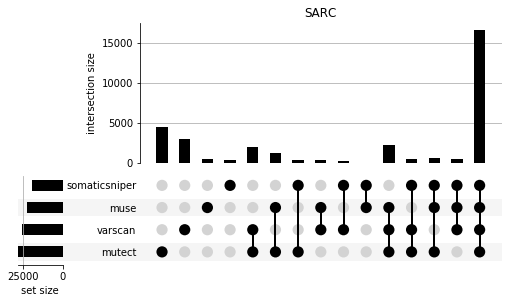

number of patients: 464
all: 587.9224137931035 1096761.955187277
mutect: 56.77370689655172 18012.778532810647
muse: 15.193965517241379 4311.78565324019
somaticsniper: 2.7413793103448274 15.872770511296077
varscan: 24.049568965517242 1951.4910774004163
mutect+muse: 40.80172413793103 8128.615859096315
mutect+somaticsniper: 9.756465517241379 322.32215647294885
mutect+varscan: 36.01077586206897 6880.0882459497625
muse+somaticsniper: 1.706896551724138 11.50029726516052
muse+varscan: 16.282327586206897 2540.6638256168258
somaticsniper+varscan: 7.644396551724138 217.71621860136744
mutect+muse+somaticsniper: 17.372844827586206 1033.1045212173005
mutect+muse+varscan: 78.26077586206897 29743.740185604936
mutect+somaticsniper+varscan: 19.088362068965516 1094.5072783516646
muse+somaticsniper+varscan: 48.69396551724138 57452.69082565398


<Figure size 432x288 with 0 Axes>

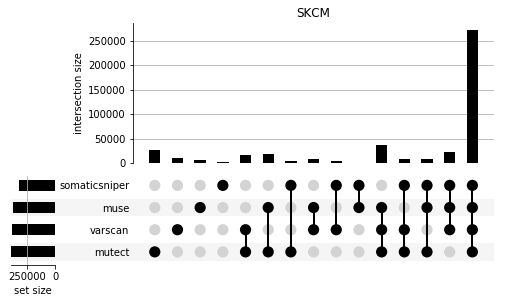

number of patients: 426
all: 248.31690140845072 308752.521639225
mutect: 66.02112676056338 26746.26481187595
muse: 7.368544600938967 279.3876490555225
somaticsniper: 1.1408450704225352 4.57640679759307
varscan: 20.089201877934272 1596.485000771452
mutect+muse: 27.715962441314552 4850.255003416431
mutect+somaticsniper: 1.8192488262910798 14.368737463907074
mutect+varscan: 80.02816901408451 23879.731600872845
muse+somaticsniper: 0.4788732394366197 1.0852344111618064
muse+varscan: 4.875586854460094 200.36245564151733
somaticsniper+varscan: 2.532863849765258 33.72779320681523
mutect+muse+somaticsniper: 2.788732394366197 42.50466177345765
mutect+muse+varscan: 62.97417840375587 18617.43830038132
mutect+somaticsniper+varscan: 10.185446009389672 336.65340320483153
muse+somaticsniper+varscan: 11.664319248826292 1721.514078996672


<Figure size 432x288 with 0 Axes>

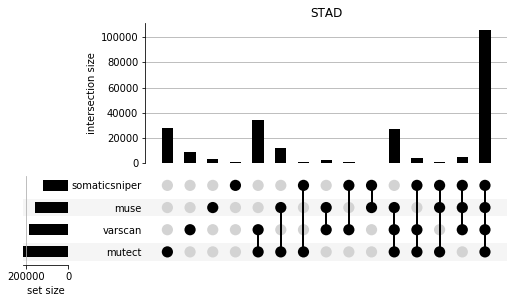

number of patients: 140
all: 10.521428571428572 60.93525510204082
mutect: 5.25 17.458928571428572
muse: 0.7 0.9528571428571427
somaticsniper: 0.32142857142857145 0.31811224489795925
varscan: 2.3285714285714287 2.8491836734693874
mutect+muse: 1.4357142857142857 2.2887244897959182
mutect+somaticsniper: 0.07857142857142857 0.11525510204081633
mutect+varscan: 1.8142857142857143 3.094081632653062
muse+somaticsniper: 0.03571428571428571 0.034438775510204085
muse+varscan: 0.17142857142857143 0.18489795918367347
somaticsniper+varscan: 0.18571428571428572 0.2083673469387755
mutect+muse+somaticsniper: 0.09285714285714286 0.08423469387755102
mutect+muse+varscan: 2.9785714285714286 9.120969387755103
mutect+somaticsniper+varscan: 0.42857142857142855 0.573469387755102
muse+somaticsniper+varscan: 0.24285714285714285 0.26959183673469383


<Figure size 432x288 with 0 Axes>

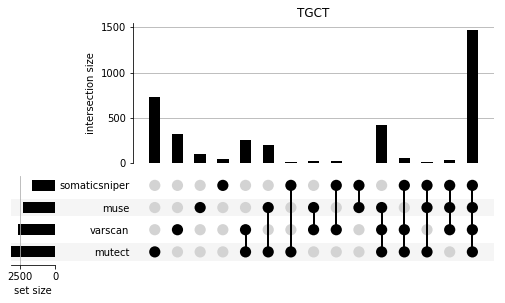

number of patients: 479
all: 7.624217118997913 42.10930914701383
mutect: 11.390396659707724 2729.8956071495504
muse: 0.35281837160751567 0.5957697185768891
somaticsniper: 0.13987473903966596 0.12448516176271894
varscan: 0.4718162839248434 0.5289551562275269
mutect+muse: 0.9311064718162839 2.406527168204462
mutect+somaticsniper: 0.05219206680584551 0.053643420312847315
mutect+varscan: 0.954070981210856 1.4049886463186612
muse+somaticsniper: 0.027139874739039668 0.03057866728265653
muse+varscan: 0.1022964509394572 0.10435798309805136
somaticsniper+varscan: 0.11064718162839249 0.13598267092629482
mutect+muse+somaticsniper: 0.07515657620041753 0.08203416128765127
mutect+muse+varscan: 1.1941544885177453 6.006145370705322
mutect+somaticsniper+varscan: 0.2630480167014614 0.39009592880086824
muse+somaticsniper+varscan: 0.2755741127348643 0.345770808181624


<Figure size 432x288 with 0 Axes>

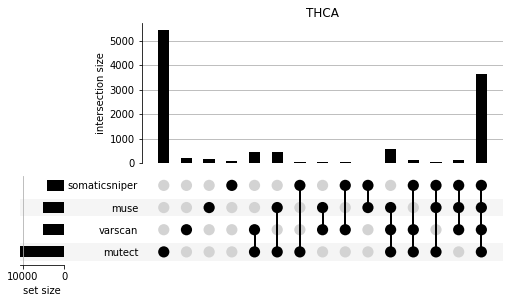

number of patients: 106
all: 17.745283018867923 4485.774741901032
mutect: 12.566037735849056 92.45318618725526
muse: 0.6792452830188679 1.0103239587041652
somaticsniper: 2.0754716981132075 2.9188323246707015
varscan: 7.273584905660377 370.48175507297975
mutect+muse: 2.292452830188679 14.414471342114634
mutect+somaticsniper: 0.4811320754716981 2.9288892844428633
mutect+varscan: 5.971698113207547 1691.6124065503734
muse+somaticsniper: 0.07547169811320754 0.12637949448202204
muse+varscan: 0.2169811320754717 0.4529191883232467
somaticsniper+varscan: 0.33962264150943394 1.1110715557137774
mutect+muse+somaticsniper: 0.5188679245283019 3.2496440014239965
mutect+muse+varscan: 2.518867924528302 16.249644001423995
mutect+somaticsniper+varscan: 0.9811320754716981 12.150587397650403
muse+somaticsniper+varscan: 0.32075471698113206 1.6518333926664301


<Figure size 432x288 with 0 Axes>

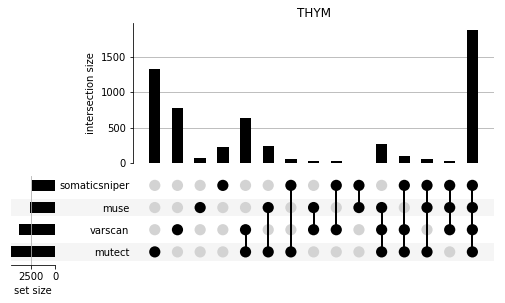

number of patients: 529
all: 1146.6446124763704 9735357.654418044
mutect: 156.3875236294896 121370.84226399992
muse: 43.300567107750474 26929.953137674613
somaticsniper: 4.361058601134215 115.05489188503472
varscan: 68.65028355387524 15433.429683284436
mutect+muse: 88.3648393194707 56136.443451817286
mutect+somaticsniper: 5.67296786389414 216.86280423526216
mutect+varscan: 130.68620037807185 67571.2701498351
muse+somaticsniper: 1.5708884688090736 21.965201668090092
muse+varscan: 19.61625708884688 12756.228922852622
somaticsniper+varscan: 14.965973534971644 2125.726630479451
mutect+muse+somaticsniper: 7.29867674858223 425.0676920108204
mutect+muse+varscan: 105.93761814744802 209624.24752627386
mutect+somaticsniper+varscan: 34.5765595463138 9995.684592322072
muse+somaticsniper+varscan: 119.27599243856332 206972.127986964


<Figure size 432x288 with 0 Axes>

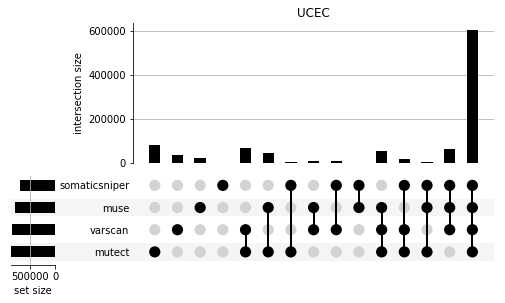

number of patients: 57
all: 126.66666666666667 293066.53801169596
mutect: 15.543859649122806 1326.0024622960914
muse: 2.508771929824561 65.65343182517698
somaticsniper: 0.5087719298245614 0.5657125269313635
varscan: 5.105263157894737 61.91874422899354
mutect+muse: 9.947368421052632 1223.9796860572485
mutect+somaticsniper: 1.719298245614035 2.5878731917513083
mutect+varscan: 11.210526315789474 1070.236380424746
muse+somaticsniper: 0.08771929824561403 0.08002462296091103
muse+varscan: 1.8421052631578947 6.308402585410896
somaticsniper+varscan: 1.7017543859649122 8.630347799322868
mutect+muse+somaticsniper: 2.9298245614035086 18.06525084641428
mutect+muse+varscan: 13.052631578947368 1454.9621421975996
mutect+somaticsniper+varscan: 2.245614035087719 51.97476146506617
muse+somaticsniper+varscan: 5.614035087719298 475.9913819636812


<Figure size 432x288 with 0 Axes>

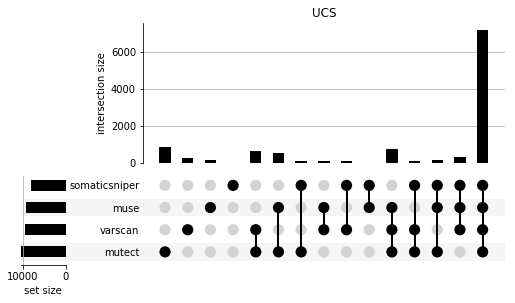

number of patients: 80
all: 14.6 1393.2400000000002
mutect: 4.1625 55.411093749999985
muse: 0.825 2.319375000000001
somaticsniper: 0.2625 0.29359375
varscan: 0.8125 1.32734375
mutect+muse: 0.7875 1.71734375
mutect+somaticsniper: 0.4125 1.2673437500000007
mutect+varscan: 1.3875 23.73734375
muse+somaticsniper: 0.05 0.04749999999999999
muse+varscan: 0.4125 0.7173437499999998
somaticsniper+varscan: 0.2 0.41
mutect+muse+somaticsniper: 0.225 0.42437500000000006
mutect+muse+varscan: 0.825 4.144375000000001
mutect+somaticsniper+varscan: 0.8 21.760000000000012
muse+somaticsniper+varscan: 0.8125 2.87734375


<Figure size 432x288 with 0 Axes>

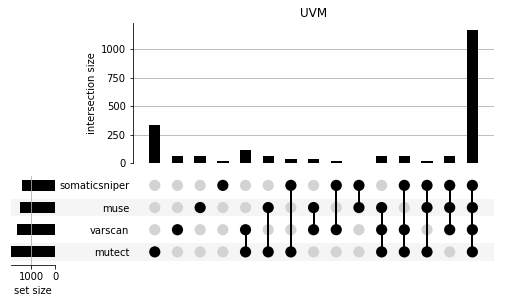

In [2]:
os.chdir(original)
possible_cancers = ('OV','PAAD','PCPG','PRAD','READ','SARC','SKCM','STAD','TGCT','THCA','THYM','UCEC','UCS','UVM')
for cancer in possible_cancers:
    os.chdir(original)
    os.chdir(cancer)
    mafs = os.listdir()

    maf_fps = {}
    for caller in possible_callers:
        for maf in mafs:
            if caller in maf: # str in the filepath
                maf_fps[caller] = maf

    #print(possible_callers)
    #print(maf_fps)

    # parse maf for each caller
    all_variants = {}
    for caller in maf_fps:
        all_variants[caller] = parse_maf(maf_fps[caller])
        
    num_callers = len(possible_callers)
    dat = []
    
    """
    #two ways
    
    for i in range(0, num_callers):
        if i == num_callers:
            break
        for j in range(i + 1, num_callers):
            set_vals = two_set(all_variants[possible_callers[i]], all_variants[possible_callers[j]])
            dat.append(set_vals)
            print(possible_callers[i], possible_callers[j])
            print(set_vals)
    """
    """
    # three ways 
    for i in range(0, num_callers):
        if i == num_callers:
            break
        for j in range(i + 1, num_callers):
            for k in range(j+1, num_callers):
                set_vals = three_set(all_variants[possible_callers[i]], all_variants[possible_callers[j]],all_variants[possible_callers[k]])
                dat.append(set_vals)
                print(possible_callers[i], possible_callers[j], possible_callers[k])
                print(set_vals)
    
    
    print(four_set(all_variants[possible_callers[0]], all_variants[possible_callers[1]],
                        all_variants[possible_callers[2]], all_variants[possible_callers[3]]))
    """
    
    # four way intersection    
    dat = four_set(all_variants[possible_callers[0]], all_variants[possible_callers[1]],
                        all_variants[possible_callers[2]], all_variants[possible_callers[3]])
    #print(possible_callers[0], possible_callers[1], possible_callers[2], possible_callers[3])
    #print(set_vals)
    
    example = from_memberships([['mutect','muse','somaticsniper','varscan'],['mutect'], ['muse'], ['somaticsniper'], 
                                ['varscan'], ['mutect', 'muse'],['mutect', 'somaticsniper'],['mutect', 'varscan'],['muse','somaticsniper'], ['muse', 'varscan'],
                            ['somaticsniper', 'varscan'],['mutect', 'muse', 'somaticsniper'], ['mutect','muse','varscan'], ['mutect', 'somaticsniper', 'varscan'],
                            ['muse','somaticsniper','varscan']],
                           data=dat)
    pyplot.figure()
    ax = plot(example)  
    pyplot.title(cancer)
    pyplot.ylabel('intersection size')
    ax['totals'].set_xlabel('set size')
    pyplot.show()
    
    

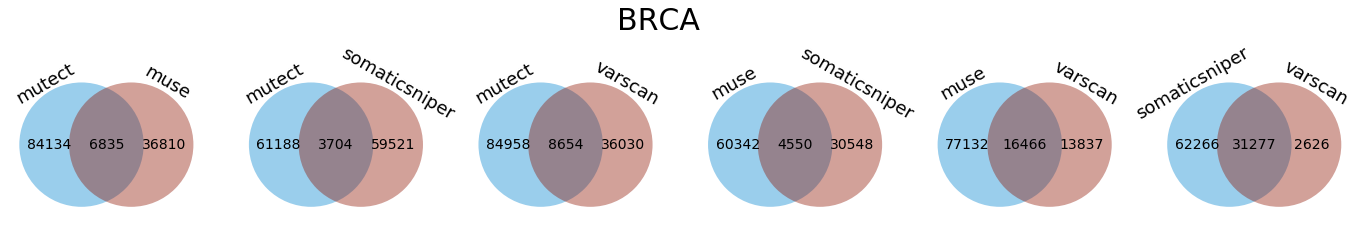

<Figure size 432x288 with 0 Axes>

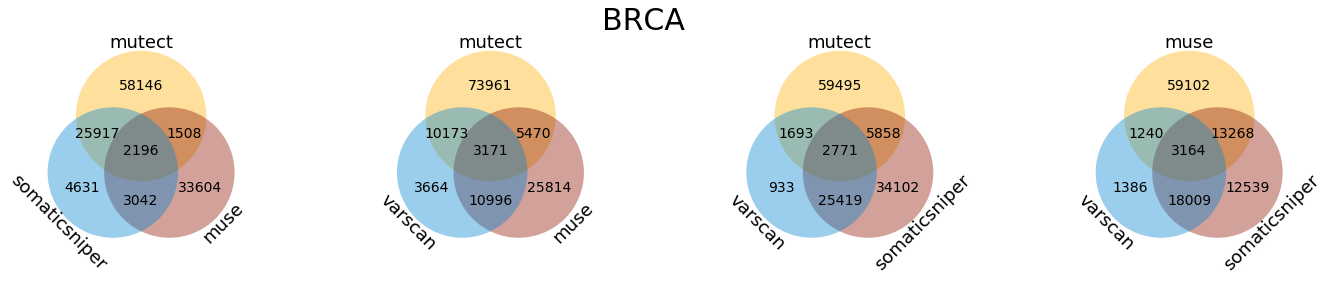

<Figure size 432x288 with 0 Axes>

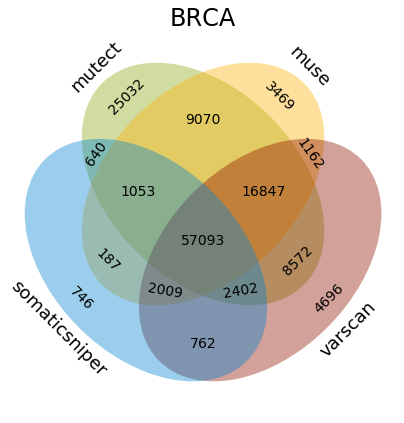

"\n# three-way venn\nsets = 'A B C'.split()\nsubsets = [1,2,3,4,5,6,7]\nax = axes[1]\nvenn3(subsets, ax=ax)\nax.set_title('venn3', fontsize=24)\n\n# four-way venn\nsets = 'A B C D'.split()\nsubsets = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]\nax = axes[2]\nvenn4(subsets, ax=ax)\nax.set_title('venn4', fontsize=24)\n\nfig.suptitle('simple_venn Demo', fontsize=30)\nplt.savefig('demo.png', bbox_inches='tight')\n"

In [4]:
import matplotlib.pyplot as plt
from itertools import combinations
from simple_venn import venn2, venn3, venn4
def two_set_venn(dat_1, dat_2):
    inter_all = 0
    diff_1_all = 0
    diff_2_all = 0

    # intersect patient keys
    patients = set(list(dat_1.keys())) & set(list(dat_2.keys()))
    dat = []
    for patient in patients:
        set_1 = dat_1[patient]
        set_2 = dat_2[patient]
        inter = len(set_1 & set_2)
        diff_1 = len(set_1 - set_2)
        diff_2 = len(set_2 - set_1)

        inter_all = inter_all + inter
        diff_1_all = diff_1_all + diff_1
        diff_2_all = diff_2_all + diff_2
    
    dat.extend([diff_1_all, diff_2_all,inter_all])
    return dat


def three_set_venn(dat_1, dat_2, dat_3):

    inter_all = 0
    diff_1_all = 0
    diff_2_all = 0
    diff_3_all = 0
    inter_12_all = 0
    inter_13_all = 0
    inter_23_all = 0

    # intersect patient keys
    patients = set(list(dat_1.keys())) & set(list(dat_2.keys())) & set(list(dat_3.keys()))
    
    dat = []
    for patient in patients:
        set_1 = dat_1[patient]
        set_2 = dat_2[patient]
        set_3 = dat_3[patient]
        inter = len(set_1 & set_2 & set_3)
        inter_12 = len(set_1 & set_2) - inter
        inter_13 = len(set_1 & set_3) - inter
        inter_23 = len(set_2 & set_3) - inter
        diff_1 = len(set_1) - inter - inter_13 - inter_12
        diff_2 = len(set_2) - inter - inter_12 - inter_23
        diff_3 = len(set_3) - inter - inter_13 - inter_23
        
        inter_all = inter_all + inter
        diff_1_all = diff_1_all + diff_1
        diff_2_all = diff_2_all + diff_2
        diff_3_all = diff_3_all + diff_3
        inter_12_all = inter_12_all + inter_12
        inter_13_all = inter_13_all + inter_13
        inter_23_all = inter_23_all + inter_23

    dat.extend([diff_1_all, diff_2_all, diff_3_all, inter_12_all, inter_13_all, inter_23_all,inter_all])
    return dat


def four_set_venn(dat_1, dat_2, dat_3, dat_4):
    dat = []
    inter_all = 0
    
    diff_1_all = 0
    diff_2_all = 0
    diff_3_all = 0
    diff_4_all = 0
    
    inter_12_all = 0
    inter_13_all = 0
    inter_14_all = 0
    inter_23_all = 0
    inter_24_all = 0
    inter_34_all = 0
    
    inter_123_all = 0
    inter_124_all = 0
    inter_134_all = 0
    inter_234_all = 0    
    
    set1_total = 0
    set2_total = 0
    set3_total = 0
    set4_total = 0
    
    # intersect patient keys
    patients = set(list(dat_1.keys())) & set(list(dat_2.keys())) & set(list(dat_3.keys())) & set(list(dat_4.keys()))
    total = 0
    for patient in patients:
        set_1 = dat_1[patient]
        set_2 = dat_2[patient]
        set_3 = dat_3[patient]
        set_4 = dat_4[patient]
        
        set1_total = set1_total + len(set_1)
        set2_total = set2_total + len(set_2)
        set3_total = set3_total + len(set_3)
        set4_total = set4_total + len(set_4)
        
        
        inter = len(set_1 & set_2 & set_3 & set_4)
        inter_123 = len(set_1 & set_2 & set_3) - inter
        inter_124 = len(set_1 & set_2 & set_4) - inter
        inter_134 = len(set_1 & set_3 & set_4) - inter
        inter_234 = len(set_2 & set_3 & set_4) - inter
        
        
        inter_12 = len(set_1 & set_2) - inter - inter_123 - inter_124
        inter_13 = len(set_1 & set_3) - inter - inter_123 - inter_134
        inter_14 = len(set_1 & set_4) - inter - inter_124 - inter_134
        inter_23 = len(set_2 & set_3) - inter - inter_123 - inter_234
        inter_24 = len(set_2 & set_4) - inter - inter_124 - inter_234
        inter_34 = len(set_3 & set_4) - inter - inter_234 - inter_134
        
        diff_1 = len(set_1) - inter - inter_13 - inter_12 - inter_14 - inter_123 - inter_134 - inter_124
        diff_2 = len(set_2) - inter - inter_12 - inter_23 - inter_24 - inter_123 - inter_124 - inter_234
        diff_3 = len(set_3) - inter - inter_13 - inter_23 - inter_34 - inter_123 - inter_134 - inter_234
        diff_4 = len(set_4) - inter - inter_14 - inter_24 - inter_34 - inter_124 - inter_134 - inter_234
        
        inter_all = inter_all + inter
        diff_1_all = diff_1_all + diff_1
        diff_2_all = diff_2_all + diff_2
        diff_3_all = diff_3_all + diff_3
        diff_4_all = diff_4_all + diff_4
        inter_12_all = inter_12_all + inter_12
        inter_13_all = inter_13_all + inter_13
        inter_14_all = inter_14_all + inter_14
        inter_23_all = inter_23_all + inter_23
        inter_24_all = inter_24_all + inter_24
        inter_34_all = inter_34_all + inter_34
        inter_123_all = inter_123_all + inter_123
        inter_124_all = inter_124_all + inter_124
        inter_134_all = inter_134_all + inter_134
        inter_234_all = inter_234_all + inter_234
        total = total + len(set_1 & set_2)
    
    #print(set1_total)
    #print(set2_total)
    #print(set3_total)
    #print(set4_total)
    
    dat.extend([diff_1_all, diff_2_all, diff_3_all, diff_4_all, inter_12_all, inter_13_all, inter_14_all,
                inter_23_all, inter_24_all, inter_34_all, inter_123_all, inter_124_all, inter_134_all, inter_234_all,inter_all]) 
    
    return dat

# BRCA Venn diagrams

os.chdir(original)
os.chdir('BRCA')
mafs = os.listdir()

maf_fps = {}
for caller in possible_callers:
    for maf in mafs:
        if caller in maf: # str in the filepath
            maf_fps[caller] = maf

    #print(possible_callers)
    #print(maf_fps)

    # parse maf for each caller
all_variants = {}
for caller in maf_fps:
    all_variants[caller] = parse_maf(maf_fps[caller])
        
num_callers = len(possible_callers)
fig, axes = plt.subplots(1, 6, figsize=(24, 4))
#two ways
sub = 0
for i in range(0, num_callers):
    if i == num_callers:
        break
    for j in range(i + 1, num_callers):
        dat = two_set(all_variants[possible_callers[i]], all_variants[possible_callers[j]])
        sets = (possible_callers[i], possible_callers[j])
        subsets = dat
        ax = axes[sub]
        venn2(subsets, sets, ax=ax)
        ax.set_title('', fontsize=24)
        sub = sub+1

fig.suptitle('BRCA', fontsize=30)  
plt.show()
plt.clf()

fig, axes = plt.subplots(1, 4, figsize=(24, 4))
# three ways 
sub = 0
for i in range(0, num_callers):
    if i == num_callers:
        break
    for j in range(i + 1, num_callers):
        for k in range(j+1, num_callers):
            dat = three_set(all_variants[possible_callers[i]], all_variants[possible_callers[j]],all_variants[possible_callers[k]])
            sets = (possible_callers[i], possible_callers[j],possible_callers[k])
            subsets = dat
            ax = axes[sub]
            venn3(subsets, sets, ax=ax)
            ax.set_title('', fontsize=24)
            sub = sub+1

fig.suptitle('BRCA', fontsize=30)
plt.show()
plt.clf()
import numpy as np
fig, axes = plt.subplots(1, 1, figsize=(7, 7))
#x = np.linspace(0,1,num=50)
#y = 8*np.power(x,2)

#plt.plot(x,y)
# four way intersection    
dat = four_set_venn(all_variants[possible_callers[0]], all_variants[possible_callers[1]],
                        all_variants[possible_callers[2]], all_variants[possible_callers[3]])
sets = (possible_callers[0], possible_callers[1],possible_callers[2], possible_callers[3])
subsets = dat
ax = axes
venn4(subsets, sets)
plt.title('BRCA', fontsize=24)
plt.show()


                    



# two-way venn

"""
# three-way venn
sets = 'A B C'.split()
subsets = [1,2,3,4,5,6,7]
ax = axes[1]
venn3(subsets, ax=ax)
ax.set_title('venn3', fontsize=24)

# four-way venn
sets = 'A B C D'.split()
subsets = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
ax = axes[2]
venn4(subsets, ax=ax)
ax.set_title('venn4', fontsize=24)

fig.suptitle('simple_venn Demo', fontsize=30)
plt.savefig('demo.png', bbox_inches='tight')
"""